# Análisis de GW170817
Un ejemplo para hallar la SNR con una plantilla Post-Newtoniana utilizando la libreria pycbc

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir

In [2]:
import numpy as np
import matplotlib.mlab as mlab
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.detector import Detector
from pycbc import waveform
from pycbc.filter import matched_filter
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.projections as mprj
import h5py

In [3]:
# Formato para las graficas
LNWDT=1.3; FNT=18
plt.rcParams['lines.linewidth'] = LNWDT; plt.rcParams['font.size'] = FNT
plt.rcParams['xtick.top'] = 'on'; plt.rcParams['ytick.right'] = 'on'
rc('mathtext', fontset='stix')

In [4]:
#### Constantes cgs #####
G = 6.67408*10**-8
c = 2.99792458*10**10
Msun = 1.98855*10**33
tSol = G*Msun/c**3

parsec = 3.08568025e18
d_source = 1.e6*parsec

T = 32*2
tevent = 1842
#tevent = 1842

In [5]:
# funcion para whitening
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [6]:
# -- Set a GPS time:
t0 = 1187008882.4    # -- GW170817

#-- Choose detector as H1, L1, or V1
detector = ['H1','L1']

In [7]:
import requests, os
%config InlineBackend.figure_format = 'retina'

In [8]:
from gwosc.locate import get_urls
import fsspec
data = {}
for i in detector:
  url = get_urls(i, t0, t0)[-1]
  print(url)
  remote_f = fsspec.open(url, mode="rb")
  if hasattr(remote_f, "open"):
    remote_f = remote_f.open()
    data[i] = h5py.File(remote_f)

https://gwosc.org/eventapi/json/GWTC-1-confident/GW170817/v3/H-H1_GWOSC_4KHZ_R1-1187006835-4096.hdf5
https://gwosc.org/eventapi/json/GWTC-1-confident/GW170817/v3/L-L1_GWOSC_4KHZ_R1-1187006835-4096.hdf5


In [9]:
strain_H1 = data['H1']["strain"]["Strain"][()]
dt_H1 = data['H1']["strain"]["Strain"].attrs["Xspacing"]

strain_L1 = data['L1']["strain"]["Strain"][()]
dt_L1 = data['L1']["strain"]["Strain"].attrs["Xspacing"]

In [10]:
if dt_H1 == dt_L1:
    delta_t = dt_H1
else:
    delta_t = dt_H1
    print ('time arrays sampling is not equal')
fs = int(1/delta_t)
fmin = 30.
fmax = 1600.

In [11]:
meta = data['H1']['meta']
gpsStart = float(meta['GPSstart'][()])
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration
print ('gps start = {0}, duration = {1}, t sampling = {2}, frequency = {3}'.format(gpsStart, duration, delta_t, fs))

gps start = 1187006835.0, duration = 4096, t sampling = 0.000244140625, frequency = 4096


In [12]:
mystart = 1187007040.
gpsStart-mystart
time = np.arange(mystart, gpsEnd, delta_t)

In [13]:
from pycbc.filter import highpass
from pycbc.types.timeseries import TimeSeries
tmerger2 = 1187008882.43

In [14]:
ts_H1_complete = TimeSeries(strain_H1, delta_t=delta_t, epoch=gpsStart)
ts_H1 = ts_H1_complete.time_slice(tmerger2 - 32, tmerger2 + 32)

ts_L1_complete = TimeSeries(strain_L1, delta_t=delta_t, epoch=gpsStart)
ts_L1 = ts_L1_complete.time_slice(tmerger2 - 32 , tmerger2  + 32)

In [15]:
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
    if ifo == 'H1':
        mydata = ts_H1
    else:
        mydata = ts_L1
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(mydata, 15)
    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

In [16]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['H1']:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step.
    psds[ifo] = interpolate(strain[ifo].psd(16), stilde[ifo].delta_f)

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

In [17]:
bb, ab = butter(4, 15.*2./fs, btype='highpass')
strain_H1_bp = filtfilt(bb, ab, strain_H1)
strain_L1_bp = filtfilt(bb, ab, strain_L1)

In [18]:
Pxx_H1, freqs = mlab.psd(strain_H1_bp, Fs = fs, NFFT=fs*16, noverlap=8*fs) # 16 s for each FFT and 8 s of overlap
Pxx_L1, freqs = mlab.psd(strain_L1_bp, Fs = fs, NFFT=fs*16, noverlap=8*fs) #

psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

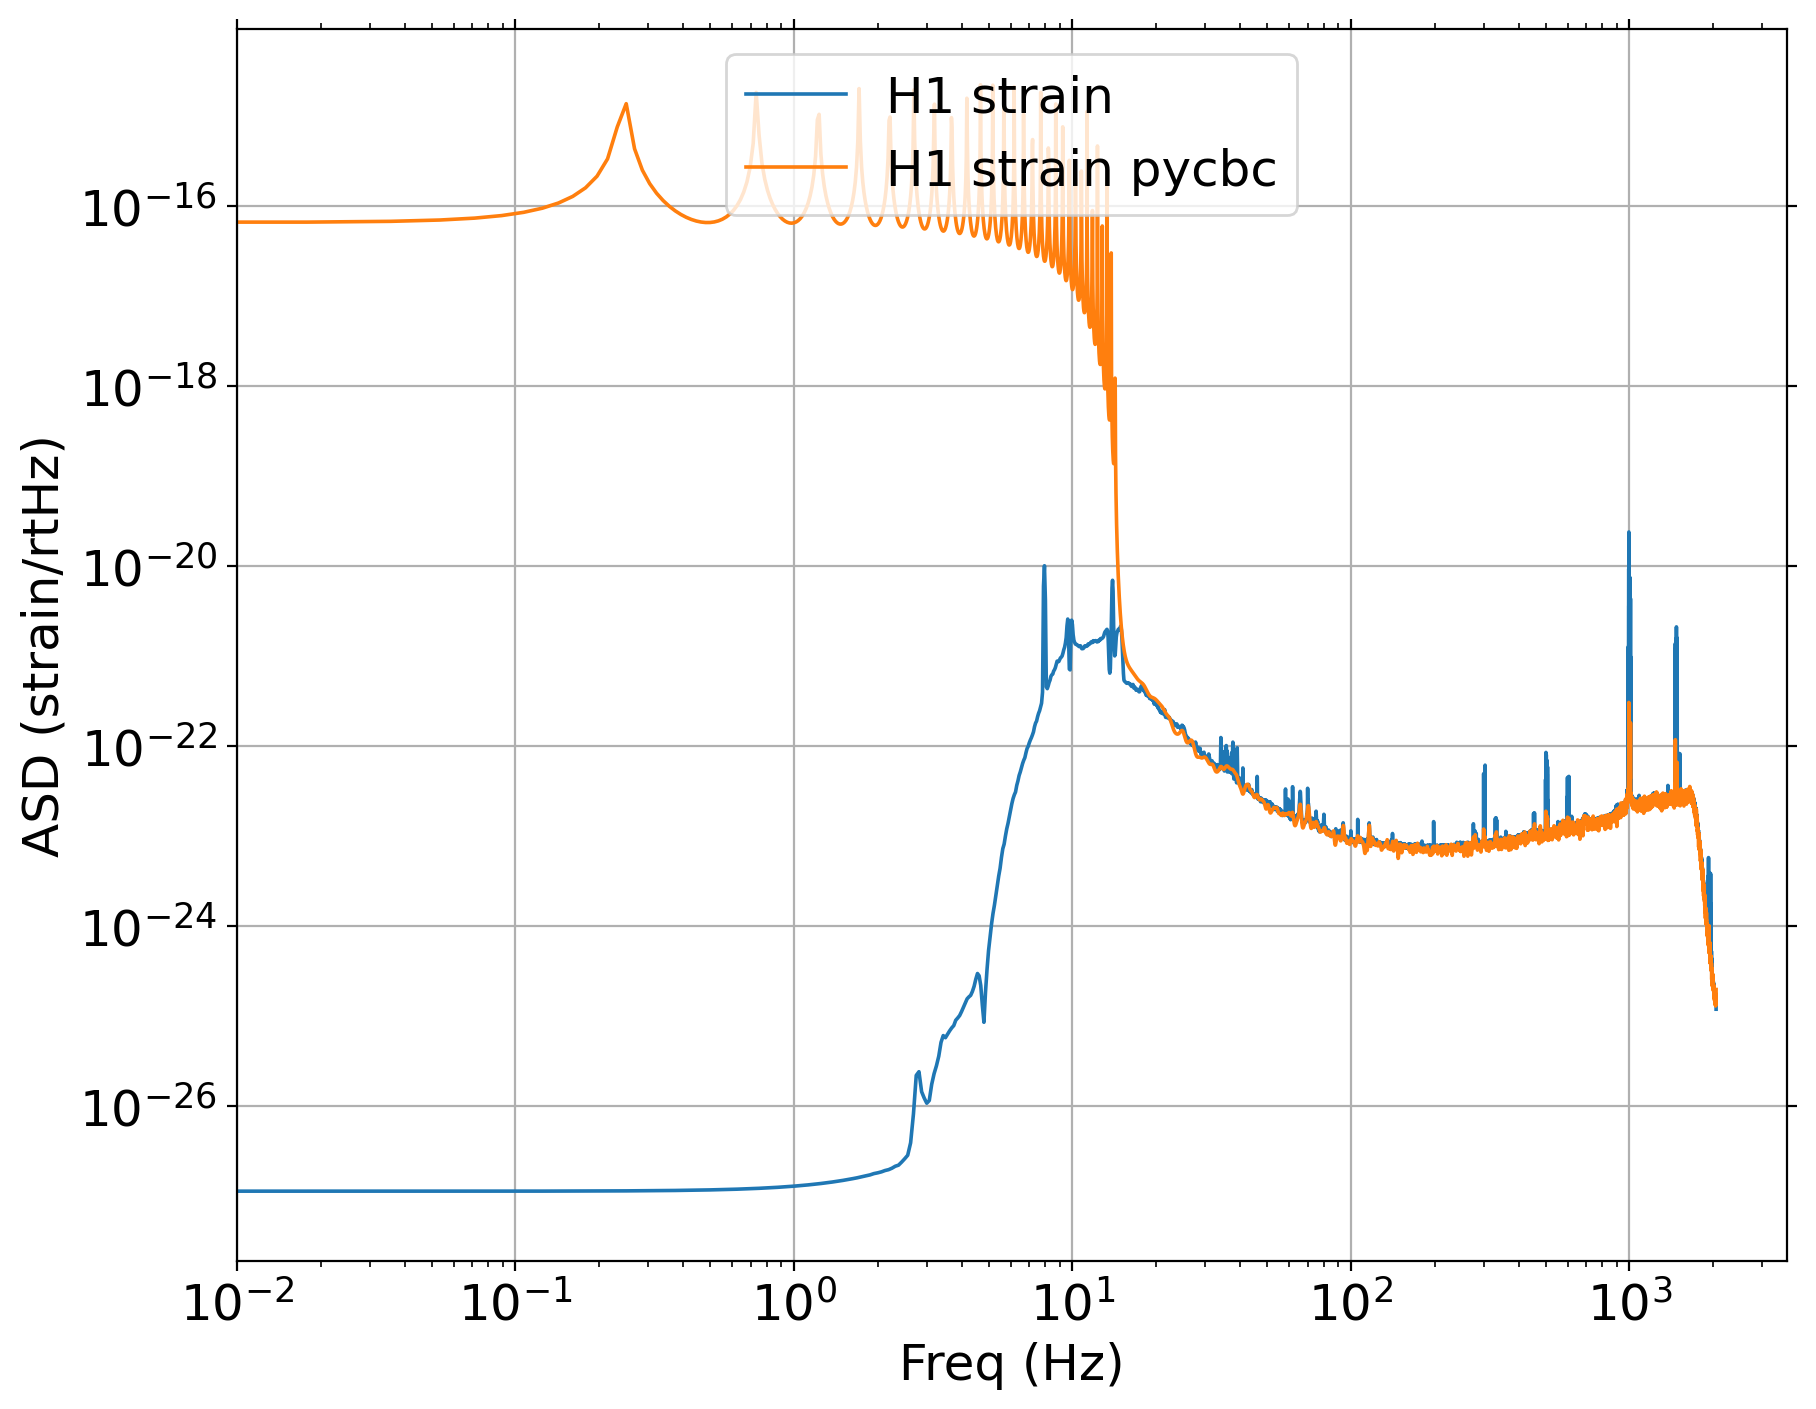

In [19]:
plt.figure(figsize=(10,8))
plt.loglog(freqs, np.sqrt(Pxx_H1),label='H1 strain')
#plt.loglog(freqs, np.sqrt(Pxx_L1),label='L1 strain')
plt.loglog(psds['H1'].sample_frequencies, np.sqrt(psds['H1']),label='H1 strain pycbc')
#plt.loglog(freqs, np.sqrt(Pxx_L1),label='L1 strain')
#plt.loglog(freqs, np.abs(template_fd)*np.sqrt(np.abs(freqs))/40, label='template')
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
#plt.axis([15, fs/2, 1e-24, 1e-20])
plt.savefig('ASD_GW170817.pdf', bbox_inches='tight')

In [20]:
mchirp = 1.197
q = 1
nu = q / (1.+q)**2
mtot = mchirp / nu**(3/5.)
m1 = 1.3758
m2 = 1.3758
lambda1 = 300
lambda2 = 300*q
print('q  = {0:.2f}'.format(q))
print('m1 = {0:.4f}, m2 = {1:.4f}'.format(m1, m2))
print('m total = {0:.2f}'.format(mtot))
print('mchirp det = {0:.3f}'.format(mchirp))
print((m1*m2/(m1+m2)**2)**(3/5.)*(m1+m2))

fs = int(1/delta_t)
fmin = 30.
fmax = 1600.

q  = 1.00
m1 = 1.3758, m2 = 1.3758
m total = 2.75
mchirp det = 1.197
1.1977034649828076


In [21]:
hp, hc = get_td_waveform(approximant='SpinTaylorT4', mass1=m1, mass2=m2,
                         f_lower=80, delta_t=delta_t,
                         lambda1=300, lambda2=10,
                         phase_order=-1,
                         amplitude_order=-1)

In [22]:
phase = waveform.utils.phase_from_polarizations(hp, hc)
f = waveform.utils.frequency_from_polarizations(hp, hc)

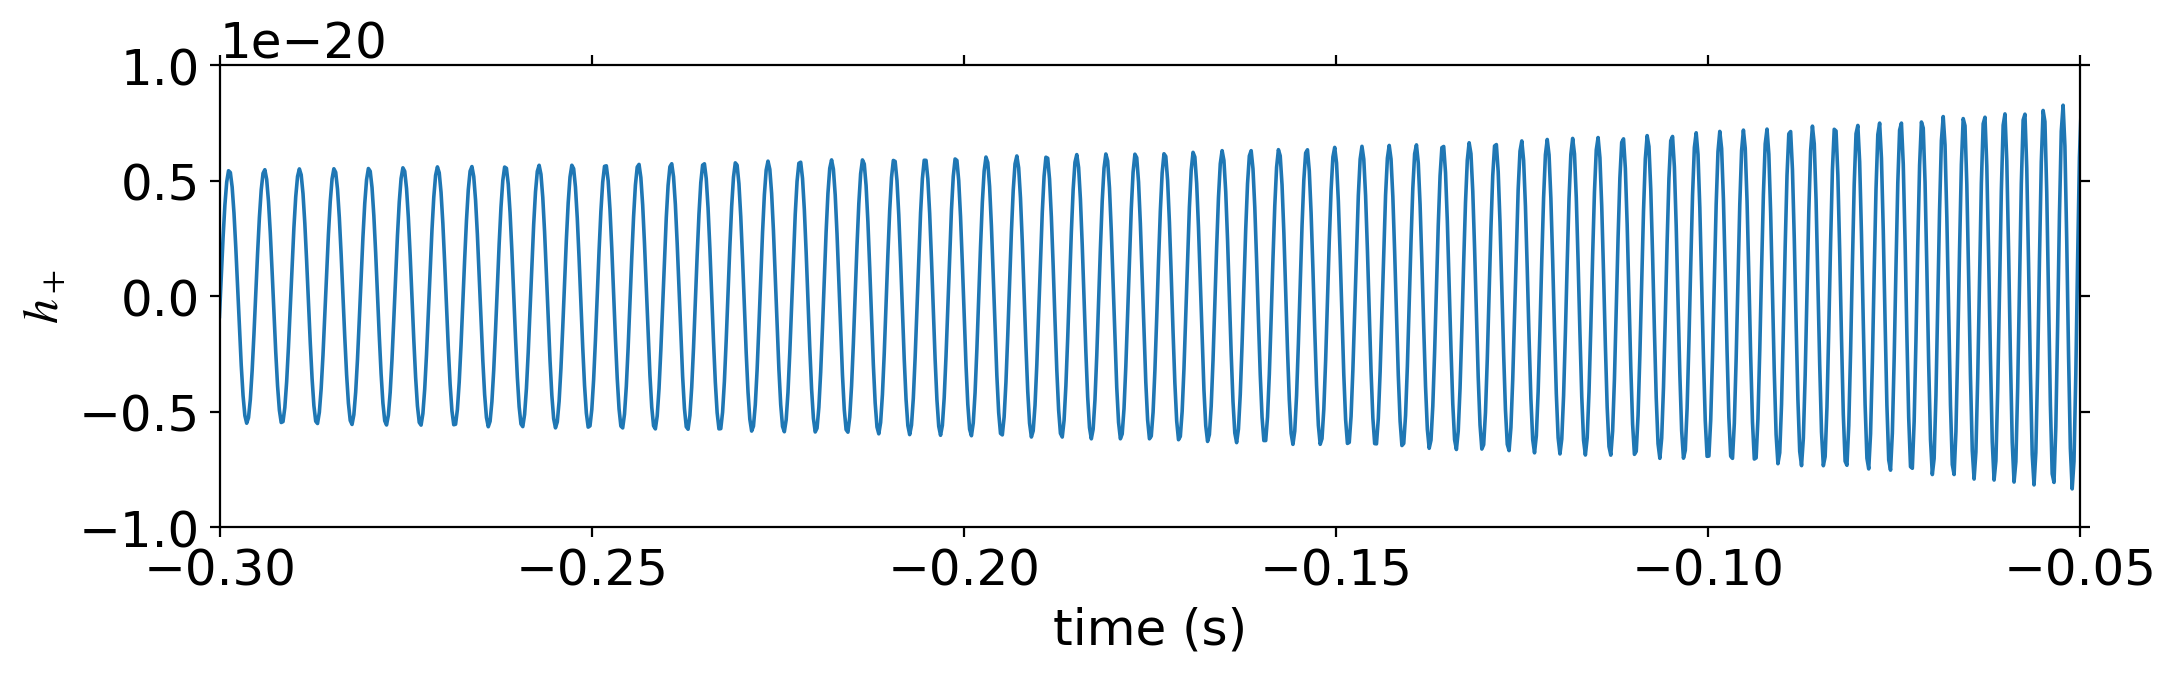

In [23]:
plt.figure(figsize=(12,3))
plt.plot(hp.sample_times, hp)
plt.xlim(-.3,-.05)
plt.ylim(-1e-20,1e-20)
plt.xlabel(r'time (s)')
plt.ylabel(r'$h_+$')
plt.savefig('h_plus.pdf', bbox_inches='tight')

In [24]:
# FFT
template_freq = np.fft.fftfreq(len(hp))*fs
dwindow = signal.tukey(len(hp), alpha=1/16.)
template_fft = np.fft.fft(hp*dwindow) / fs
ASD_template = np.absolute(template_fft)*np.sqrt(np.absolute(template_freq))
df = template_freq[1] - template_freq[0]

## FD waveform

In [25]:
# Generate a template to filter with
htilde_p, htilde_c = get_fd_waveform(approximant='TaylorF2', mass1=m1, mass2=m2,
                         f_lower=25, delta_f=1.0/T)

In [26]:
indx = np.where((time>time[0]+tevent-14*T/16)&(time<time[0]+tevent+2*T/16)) # s around the event
dlength = len(strain_H1[indx])
# we need to pad the template to match the data lenght
htilde_c.resize(dlength/2 + 1)
htilde_p.resize(dlength/2 + 1)

hf_p = np.concatenate((htilde_p.numpy()[:],np.conjugate(htilde_p.numpy()[-1:0:-1])))
hf_c = np.concatenate((htilde_c.numpy()[:],np.conjugate(htilde_c.numpy()[-1:0:-1])))

In [32]:
f_isco = 6**-1.5/tSol/mtot/np.pi
print(f_isco, htilde_p.sample_frequencies[-1], 1./T)

1598.9220506063955 2047.984375 0.015625


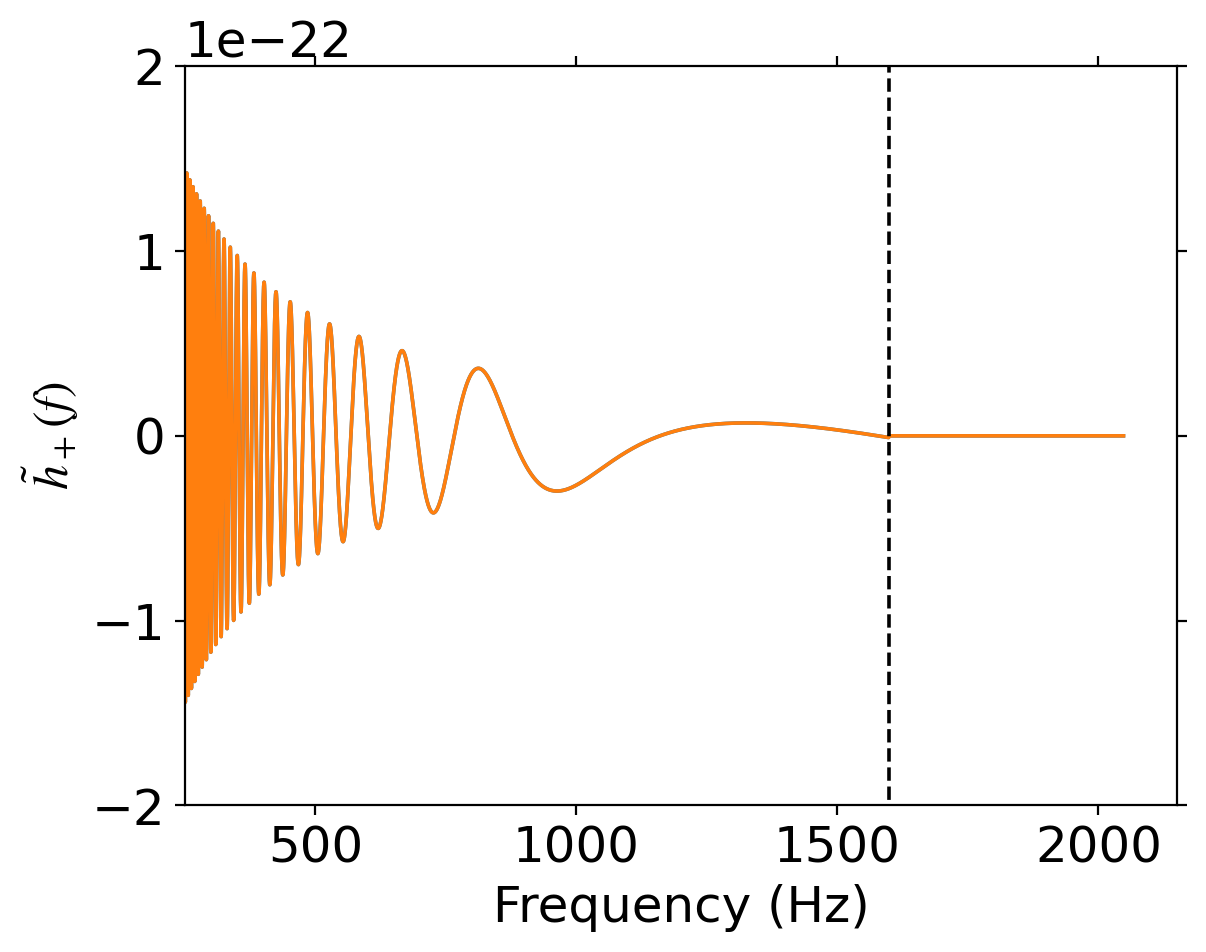

In [33]:
plt.figure()
plt.plot(htilde_p.sample_frequencies, (htilde_p).real())
plt.plot(htilde_p.sample_frequencies, (htilde_c*np.exp(1j*np.pi/2.)).real())
plt.plot([f_isco, f_isco],[-3e-22, 3e-22], 'k--')
#plt.plot(template_freq[:len(template_freq)/2], (template_fft[:len(template_freq)/2]).real)
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$\tilde{h}_+(f)$')
plt.xlim(250)
plt.ylim(-2e-22,2e-22)
plt.savefig('hf_plus.pdf',bbox_inches='tight')

In [34]:
print('len data = {0:d}, len hp = {1:d}, len hc = {2:d}'.format(dlength, len(htilde_c), len(htilde_p)))
print('time interval =', time[indx][-1]- time[indx][0])

len data = 262143, len hp = 131072, len hc = 131072
time interval = 63.99951171875


In [35]:
template_fd = hf_p + 1.j*hf_c # complex template

In [36]:
print(len(template_fd) == dlength) # verify lengths are the same

True


Detector H1, SNRmax = 4.6727, phase = 0.1967, time event = 1187008833.6597
Detector L1, SNRmax = 4.6244, phase = -1.2009, time event = 1187008874.8796


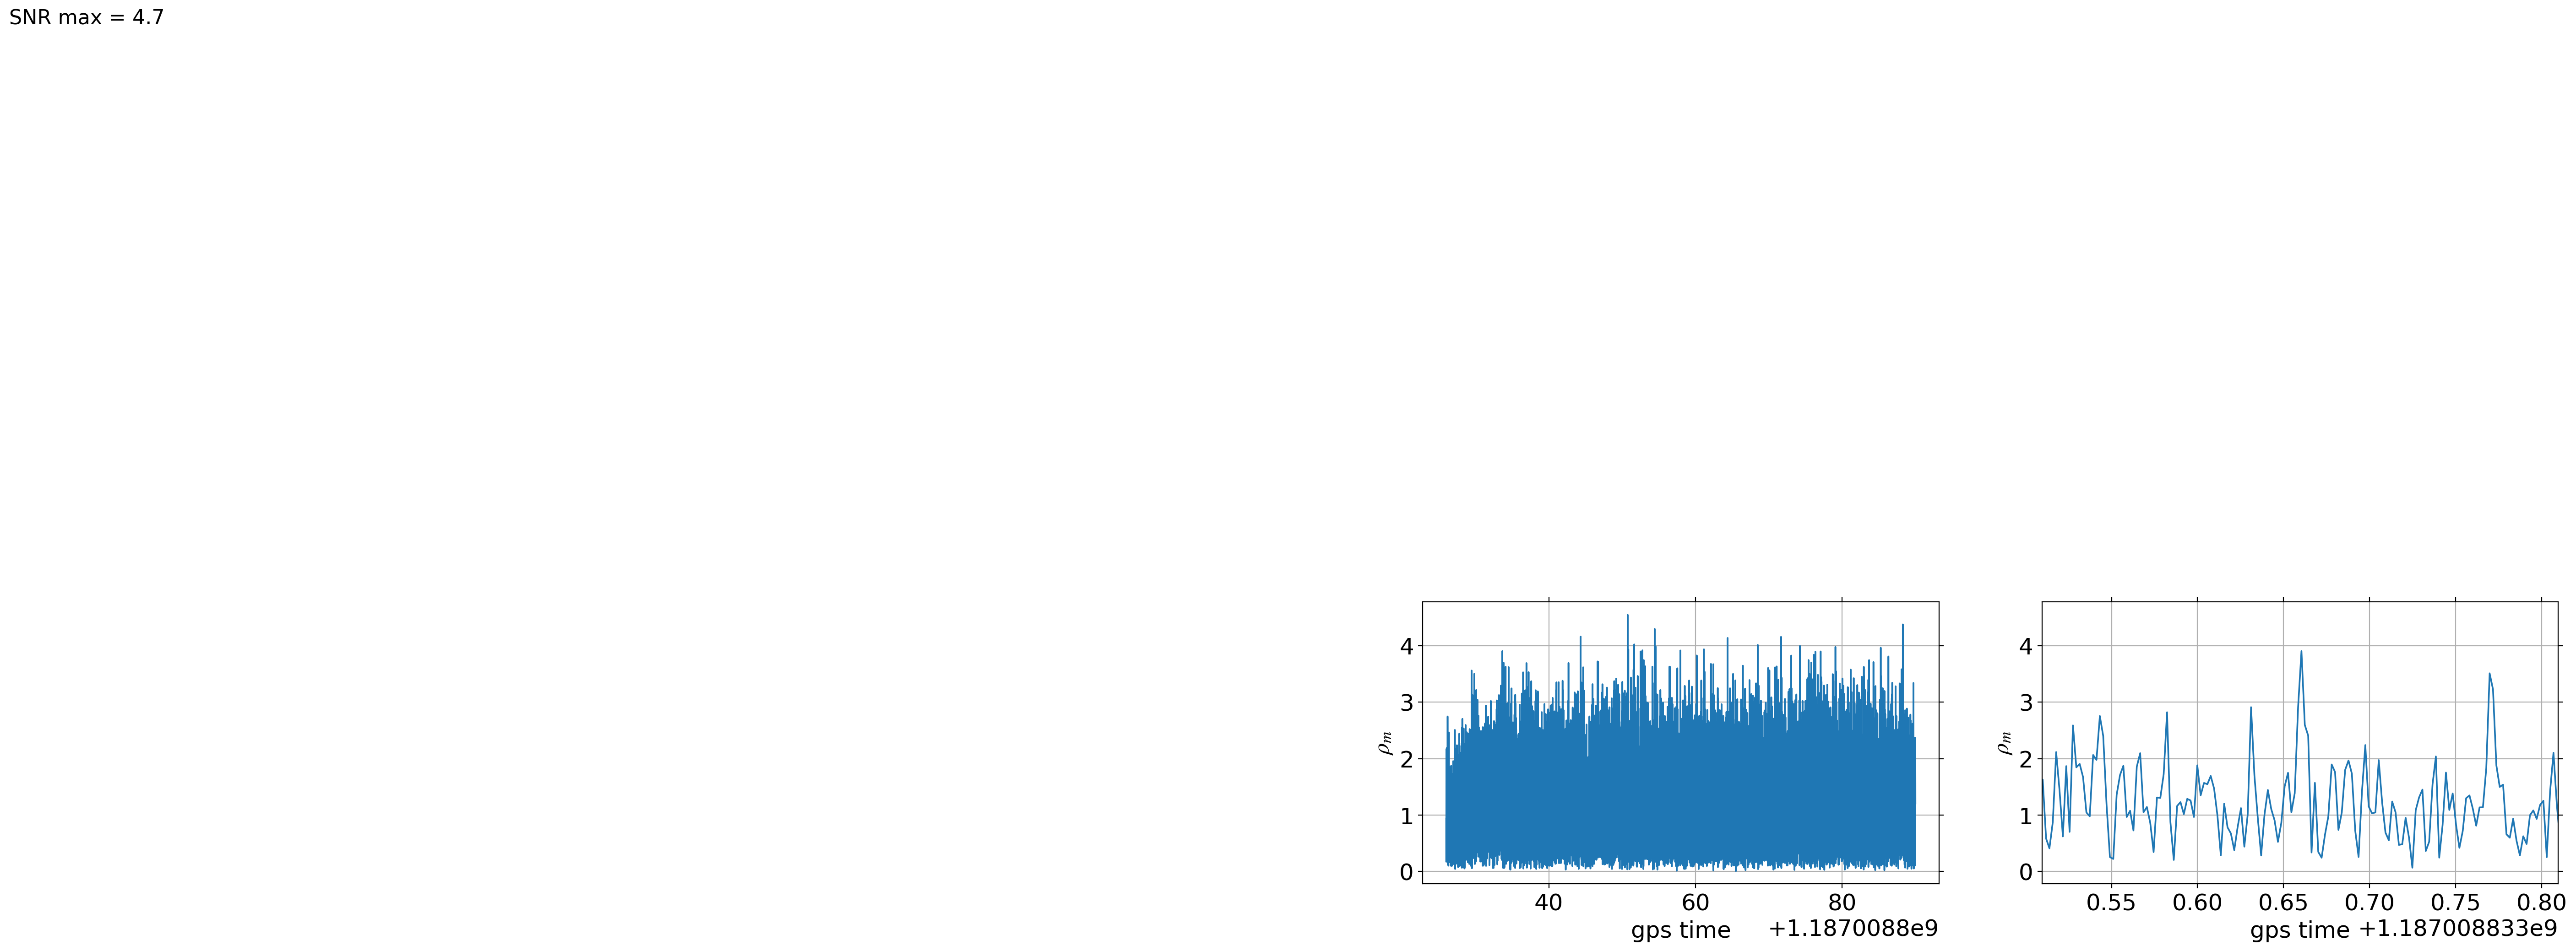

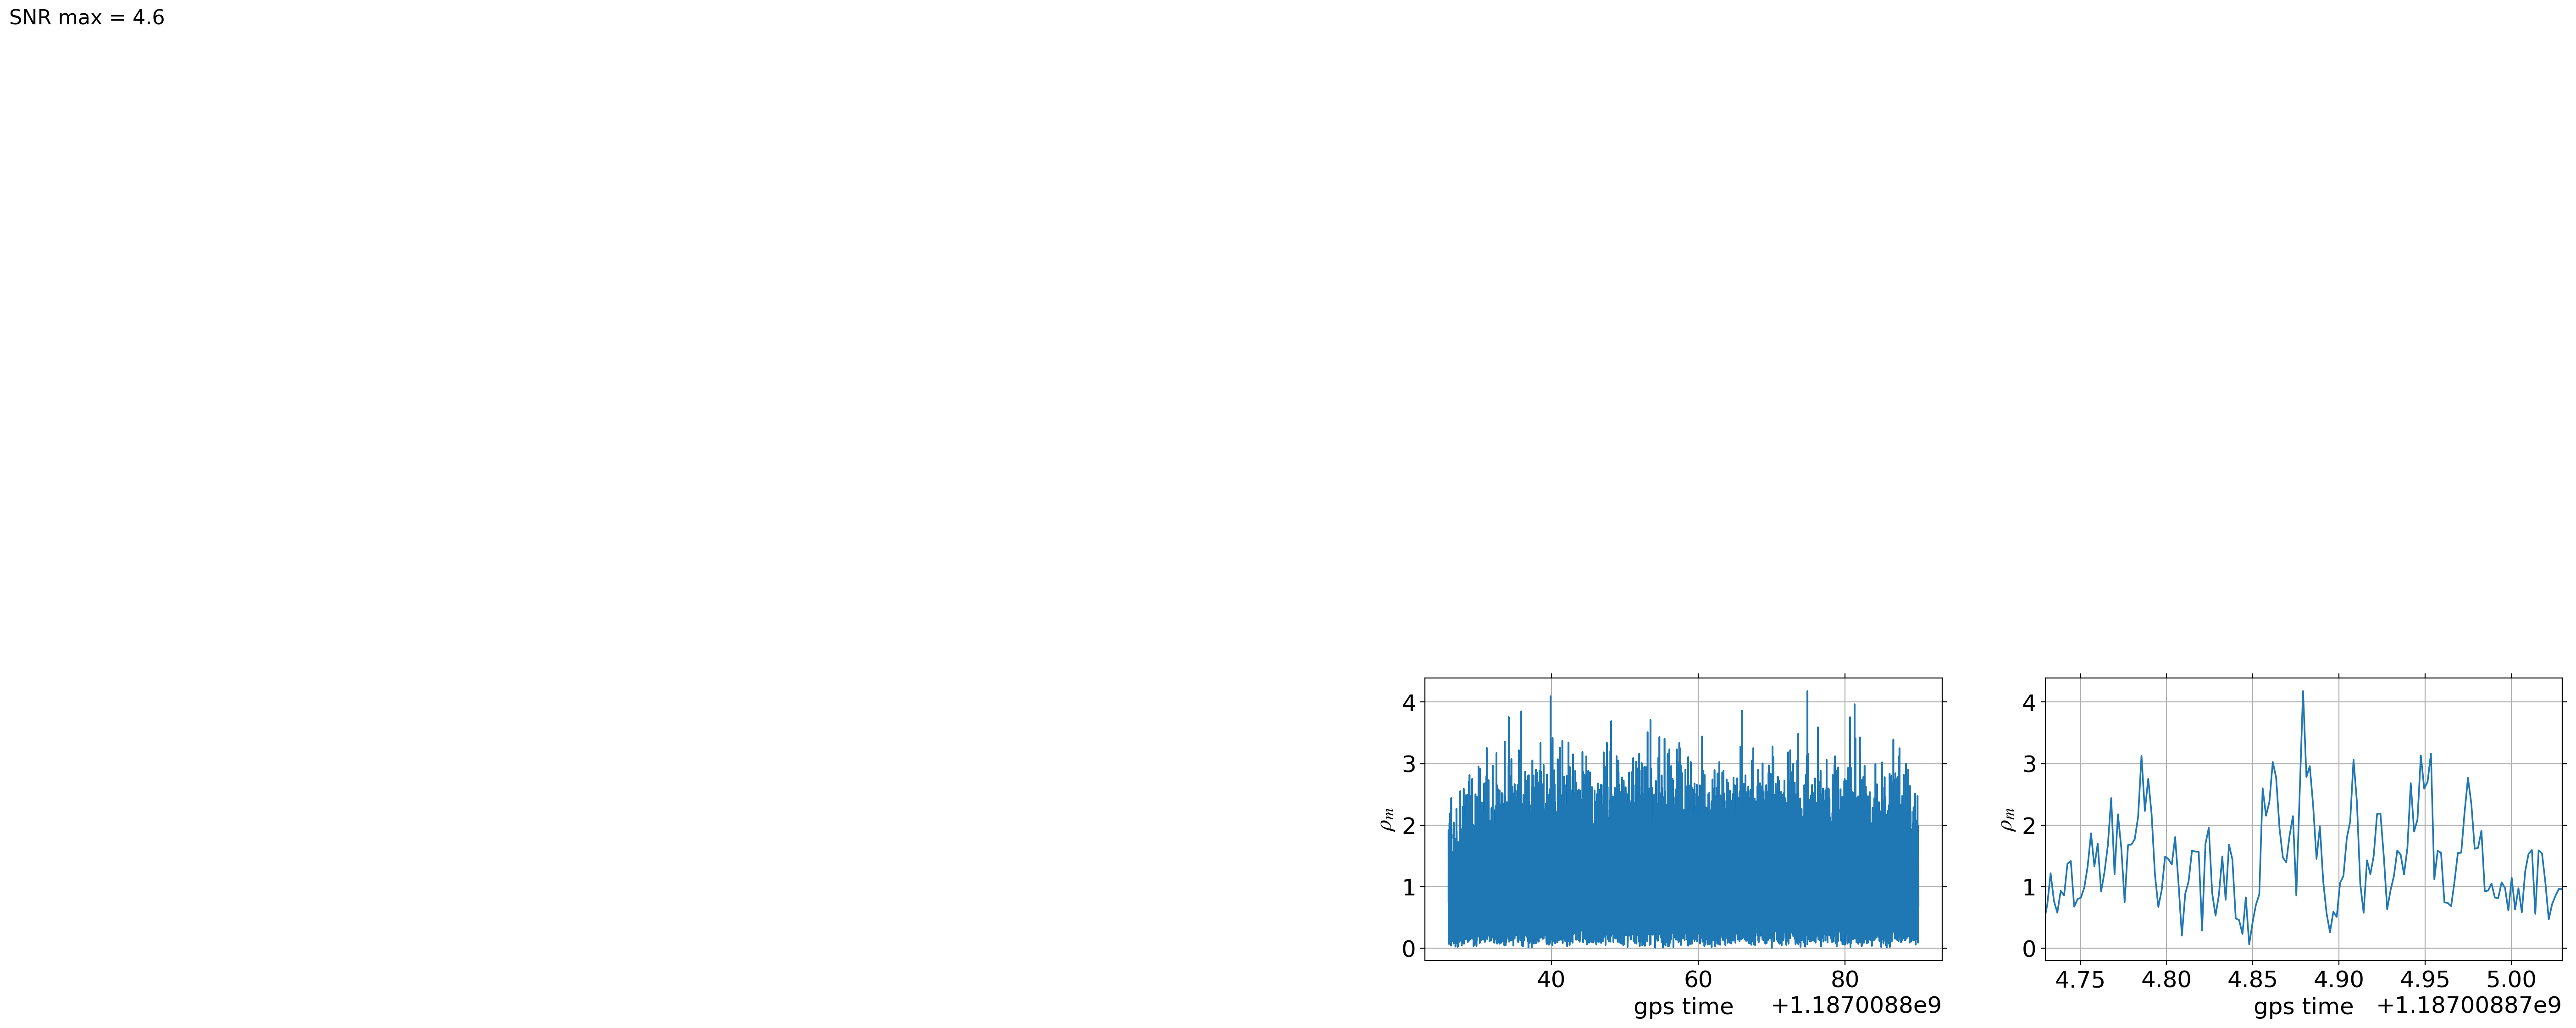

In [37]:
dwindow = signal.tukey(dlength, alpha=1./16.)
rho_i = []
tmerger = []
phase_merger = []
detectors = ['H1', 'L1']
f1 = []
f2 = []
Deff = []
I73 = []
for det in detectors:
    if det == 'L1':
        data = strain_L1_bp.copy()[indx]
        Pxx = Pxx_L1.copy()
    else:
        data = strain_H1_bp.copy()[indx]
        Pxx = Pxx_H1.copy()

    datafreq = np.fft.fftfreq(data.size) * fs
    data_fft = np.fft.fft(data*dwindow) / fs

    power_vec = np.interp(np.abs(datafreq), freqs, Pxx)

    optimal = data_fft * template_fd.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs
    df = np.abs(datafreq[1] - datafreq[0])

    sigmasq = 1*(template_fd * template_fd.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma
    SNR = np.abs(SNR_complex)

    f1.append(1*(template_fd * template_fd.conjugate() / power_vec * np.abs(datafreq)).sum() * df / sigmasq)
    f2.append(1*(template_fd * template_fd.conjugate() / power_vec * datafreq**2).sum() * df / sigmasq )

    I73.append(np.abs(sigmasq))

    indmax = np.argmax(SNR)
    SNRmax = SNR[indmax]
    t_max = time[indx][indmax]
    phase_max = np.angle(SNR_complex[indmax])

    tmerger.append(t_max)
    rho_i.append(SNRmax)
    phase_merger.append(phase_max)

    Deff.append(sigma / SNRmax)

    print ('Detector {0}, SNRmax = {1:.4f}, phase = {2:.4f}, time event = {3:.4f}'
           .format(det, SNRmax, phase_max, t_max))
    # plots
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot( time[indx][::8], np.abs(SNR_complex)[::8])
    plt.xlabel('gps time')
    plt.ylabel(r'$\rho_m$')
    plt.grid('on')
    #plt.title(detector)
    plt.text(gpsStart + 1795, 15, 'SNR max = {0:.1f}'.format(SNRmax),fontsize=16)
    plt.subplot(1,2,2)
    plt.plot(time[indx][::8], np.abs(SNR_complex)[::8])
    plt.xlabel('gps time')
    plt.ylabel(r'$\rho_m$')
    plt.grid('on')
    plt.xlim(t_max - 0.15, t_max + 0.15)
    #plt.xlim(tmergerL-0.1,tmergerL+0.01)
    #plt.title(detector)
    #plt.text(gpsStart + 1795, 15, 'SNR max = {0:.1f}'.format(SNRmax),fontsize=16)
    plt.savefig('MatchedFilter_'+det+'.pdf', bbox_inches='tight')